In [1]:
from montecarlo import *
from heston import *

from matplotlib import pyplot as plt

In [2]:
def getPhiAB(u, tau, k, sig, theta, rho, v):
    
    xi = k - sig * rho * u * 1j
    d = np.sqrt( xi ** 2 + sig**2 * (1j * u + u ** 2) + 0j)
    
    A1 = (1j * u + u ** 2) * np.sinh(d * tau / 2)
    A2 = (d * np.cosh(d * tau / 2) + xi * np.sinh(d * tau / 2))
    A = A1 / A2
    
    B = d * np.exp(k * tau / 2) / A2
    
    pred_phi = np.exp(-k * theta * rho * tau * u * 1j / sig - A * v) * \
        B ** (2 * k * theta / sig ** 2)
    return pred_phi

    
def getOptionPriceAB(S, K, Nu, tau, r, k, sig, theta, rho, v, isCall=True):
    
    if not isinstance(S, np.ndarray):
        S = np.asarray([S])
    if not isinstance(K, np.ndarray):
        K = np.asarray([K])
    if not isinstance(v, np.ndarray):
        v = np.asarray([v])
    #dims go as follow:
    #K S v u
    S = S.reshape(1, -1, 1, 1)
    K = K.reshape(-1, 1, 1, 1)
    v = v.reshape(1, 1, -1, 1)

    Ns = S.size
    Nk = K.size
    Nv = v.size

    un, hn = getMesh(Nu)

    un = un.reshape(1, 1, 1, -1)
    hn = hn.reshape(1, 1, 1, -1)
    
    xn = np.log(S * np.exp(r * tau) / K)
    

    batchSize = 100

    I1 = np.zeros((Nk, Ns, Nv, 1))
    I2 = np.zeros((Nk, Ns, Nv, 1))
    for i in range(Nu // batchSize):
        start = i * batchSize
        end = start + batchSize
        unbatch = un[:, :, :, start:end]
        hnbatch = hn[:, :, :, start:end]
        
        pred_phi = getPhiAB(unbatch, tau, k, sig, theta, rho, v)
        pred_phi_tilda = getPhiAB(unbatch - 1j, tau, k, sig, theta, rho, v)

        F1 = np.exp(1j * unbatch * xn) * pred_phi / (1j * unbatch)
        F2 = np.exp(1j * unbatch * xn) * pred_phi_tilda / (1j * unbatch)

        F1 = F1.real * hnbatch
        F2 = F2.real * hnbatch
        I1 += np.sum(F1, axis=-1, keepdims=True) / np.pi
        I2 += np.sum(F2, axis=-1, keepdims=True) / np.pi
    assert I1.shape == (Nk, Ns, Nv, 1)
    if isCall:
        P1 = 0.5 + I1
        P2 = 0.5 + I2
        res = S * P2 - np.exp(-r * tau) * K * P1
    else:
        P1 = 0.5 - I1
        P2 = 0.5 - I2
        res = np.exp(-r * tau) * K * P1 - S * P2
    return res.squeeze()

In [3]:
def getPhiABder(u, tau, k, sig, theta, rho, v):
    xi = k - sig * rho * u * 1j
    d = np.sqrt( xi ** 2 + sig**2 * (1j * u + u ** 2) + 0j)
    
    
    c = np.cosh(d * tau / 2)
    s = np.sinh(d * tau / 2)
    
    A1 = (1j * u + u ** 2) * s
    A2 = (d * c + xi * s)
    A = A1 / A2
    
    B = d * np.exp(k * tau / 2) / A2
    
    D = np.log(d) + (k - d) * tau / 2 - np.log( (d + xi)/2 + (d-xi)/2 * np.exp(-d*tau) )
    
    pred_phi = np.exp(-k * theta * rho * tau * u * 1j / sig - A * v + 2 * k * theta / sig ** 2 * D)
    
    der1 = -A
    der2 = 2 * k / sig ** 2 * D - k * rho * tau * 1j * u / sig
    
    d_rho = -1j * u * sig * xi / d

    A1_rho = -1j * u * sig * tau * xi / (2 * d) * (u ** 2 + 1j * u) * c
    A2_rho = -(2 + xi * tau) * sig * 1j * u / (2 * d) * (xi * c + d * s)
    
    B_rho = np.exp(k * tau / 2) * (d_rho - d * A2_rho / A2) / A2
    A_rho = (A1_rho - A * A2_rho) / A2
    
    D_rho = B_rho / B
       
    der3 = -k * theta * tau * 1j * u / sig - v * A_rho + 2 * k * theta / sig **2 * D_rho
    
    A_k = A_rho * 1j / (u * sig)
    B_k = tau / 2 * B + B_rho * 1j / (u * sig)
    D_k = B_k / B
    
    der4 = -theta * rho * tau * 1j * u / sig - v * A_k + 2 * theta / sig**2 * D + 2 * k * theta / sig ** 2 * D_k
    
    d_sig = (sig * (1j * u + u ** 2) + rho * 1j * u * (sig * rho * 1j * u - k)) / d
    A1_sig = (1j * u + u ** 2) * tau / 2 * c * d_sig
    A2_sig = d_sig * ( c * (1 + xi * tau / 2) + d * tau / 2 * s) - s * rho * 1j * u
    
    A_sig = (A1_sig - A * A2_sig) / A2
    
    D_sig = d_sig / d - A2_sig / A2
    
    der5 = k * theta * rho * tau * 1j * u / sig ** 2 - v * A_sig - 4 * k * theta / sig**3 * D\
        + 2 * k * theta / sig ** 2 * D_sig
    
    return pred_phi, der1, der2, der3, der4, der5

In [4]:
def getPhiABderFinite(u, tau, k, sig, theta, rho, v):
    pred_phi = getPhiAB(u, tau, k, sig, theta, rho, v)
    
    eps = 1e-10
    denom = 1 / (2 * eps * pred_phi)
    der1 = (getPhiAB(u, tau, k, sig, theta, rho, v + eps) - getPhiAB(u, tau, k, sig, theta, rho, v - eps)) * denom 
    der2 = (getPhiAB(u, tau, k, sig, theta + eps, rho, v) - getPhiAB(u, tau, k, sig, theta - eps, rho, v)) * denom 
    der3 = (getPhiAB(u, tau, k, sig, theta, rho + eps, v) - getPhiAB(u, tau, k, sig, theta, rho - eps, v)) * denom 
    der4 = (getPhiAB(u, tau, k + eps, sig, theta, rho, v) - getPhiAB(u, tau, k - eps, sig, theta, rho, v)) * denom 
    der5 = (getPhiAB(u, tau, k, sig + eps, theta, rho, v) - getPhiAB(u, tau, k, sig - eps, theta, rho, v)) * denom 
    return pred_phi, der1, der2, der3, der4, der5

In [43]:
r = 0.0
d = 0.55
k = 2.5
sig = 0.9
theta = 0.015
rho = 0.8


S0 = 1.0
K = 1.0
T = 1.5

Kn = K * np.exp( np.linspace(-np.log(15), np.log(5), 100) )
Sn = S0 * np.exp( np.linspace(-np.log(15), np.log(2), 120) )

#Kn = Kn.reshape(-1, 1)
#Sn = Sn.reshape()


Nt = 100
Nu = 1000
tn = np.linspace(0, T, Nt)

v0 = 0.175
x0 = np.log(S0)

In [44]:
C1 = getOptionPrice(S0, Kn, Nu, T, r, k, sig, theta, rho, v0)

C2 = getOptionPriceAB(S0, Kn, Nu, T, r, k, sig, theta, rho, v0)

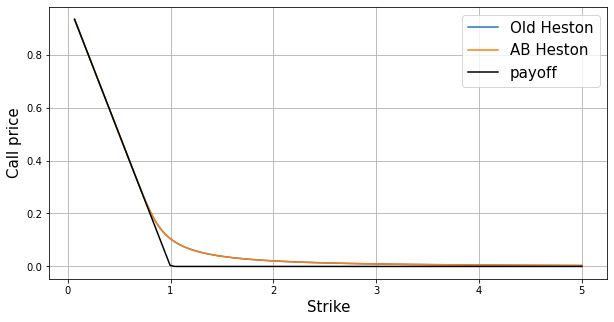

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(Kn, C1, label='Old Heston')
plt.plot(Kn, C2, label='AB Heston')
plt.plot(Kn, np.maximum(S0 - Kn, 0.0), c='k', label='payoff')

plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("Call price", fontsize=15)
None

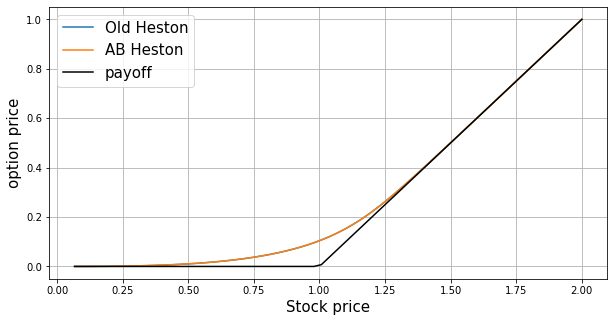

In [46]:
C1 = getOptionPrice(Sn, K, Nu, T, r, k, sig, theta, rho, v0)

C2 = getOptionPriceAB(Sn, K, Nu, T, r, k, sig, theta, rho, v0)

plt.figure(figsize=(10, 5))
plt.plot(Sn, C1, label='Old Heston')
plt.plot(Sn, C2, label='AB Heston')
plt.plot(Sn, np.maximum(Sn - K, 0.0), c='k', label='payoff')

plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Stock price", fontsize=15)
plt.ylabel("option price", fontsize=15)
None

In [47]:
np.linalg.norm(C1 - C2)

5.1742863517521045e-05

In [39]:
u = 8
tau = T

phi, der1, der2, der3, der4, der5 = getPhiABderFinite(u, tau, k, sig, theta, rho, v0)

phi_, der1_, der2_, der3_, der4_, der5_ = getPhiABder(u, tau, k, sig, theta, rho, v0)

d1 = np.asarray((der1, der2, der3, der4, der5))
d2 = np.asarray((der1_, der2_, der3_, der4_, der5_))

In [40]:
phi, der1, der2, der3, der4, der5

((0.2843696621215394+0.2652487366424468j),
 (-4.1169797596986735+3.379647670195106j),
 (-14.935228322274437+10.612294218351998j),
 (-1.1751305067750613-0.5368676834682214j),
 (-0.015047736360621698-0.09953981989221095j),
 (0.8333052472914338-0.34793715332589337j))

In [41]:
phi_, der1_, der2_, der3_, der4_, der5_

((0.28436966212153936+0.26524873664244675j),
 (-4.116979639948353+3.3796475457888246j),
 (-14.935228536353444+10.612294087455496j),
 (-1.1751304496917907-0.5368674858783834j),
 (-0.015046442623900723-0.09953879793246016j),
 (0.8333039943037155-0.347936189252906j))

In [42]:
np.abs(d1 - d2)

array([1.72676177e-07, 2.50925717e-07, 2.05670231e-07, 1.64868324e-06,
       1.58095381e-06])

In [52]:
%%timeit
phi, der1, der2, der3, der4, der5 = getPhiABderFinite(u, tau, k, sig, theta, rho, v0)

87.4 µs ± 2.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [53]:
%%timeit
phi_, der1_, der2_, der3_, der4_, der5_ = getPhiABder(u, tau, k, sig, theta, rho, v0)

21.9 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
